In [355]:
import torch
import torchvision
import clip
import numpy as np
import matplotlib.pyplot as plt

In [273]:
# import requests
# from urllib.parse import urlencode

# base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
# public_key = 'https://disk.yandex.ru/d/vr6SuXgW-8tgbg' # link

# final_url = base_url + urlencode (dict (public_key = public_key))
# response = requests.get(final_url)
# download_url = response.json () [ 'href']
# download_response = requests.get (download_url)
# with open( 'train.zip', 'wb') as f:
#     f.write (download_response.content)

In [274]:
# z = zipfile.ZipFile('train.zip')
# z.extractall()

In [275]:
data = torchvision.datasets.ImageFolder('train')
idx_to_classes = {v:k for (k,v) in data.class_to_idx.items()}

In [276]:
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

In [344]:
# one image encoding
def get_image_features(image):
    with torch.no_grad():
        input_image = preprocess(image).unsqueeze(0).to(device)
        features = model.encode_image(input_image)
    return features

In [345]:
# all images encoding
def get_all_features(dataset):
    all_features = torch.tensor([]).to(device)
    for image, _ in dataset:
        with torch.no_grad():
            image_features = get_image_features(image)
            all_features = torch.cat((all_features, image_features))
    return all_features

In [346]:
# calculate cosine distance
def get_similarity(image_features, all_features):
    all_distances = torch.tensor([]).to(device)
    cosine_distance = torch.nn.CosineSimilarity(dim=1)
    for feature in all_features:
        distance = cosine_distance(image_features, feature)
        all_distances = torch.cat((all_distances, distance)).to(device)
    return all_distances

In [358]:
# search for top k similar images
def search_topk(image_label, all_features, k=5):
    image , _ = image_label
    image_features = get_image_features(image)
    all_distances = get_similarity(image_features, all_features)
    top_distances, top_indices = torch.topk(all_distances, k)
    return top_distances, top_indices

In [ ]:
all_features = get_all_features(data)

In [359]:
top_distances, idx = search_topk(data[42], all_features)

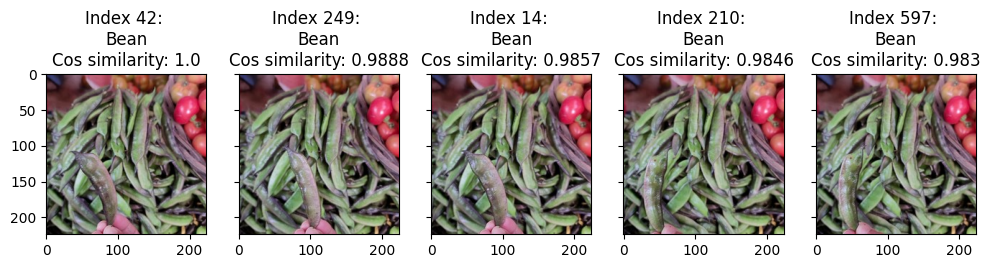

In [360]:
# plot results
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(12,9), sharey=True)

for i in range(len(idx)):
    label = idx_to_classes[data[idx[i].item()][1]]
    ax[i].imshow(data[idx[i].item()][0])
    ax[i].set_title(
        f'Index {idx[i]}: \n{label}\nCos similarity: {round(top_distances[i].item(), 4)}'
    )